In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv(r'C:\Users\dheof\Desktop\Help\Purwadhika\Csv_Files\titanic_z.csv')
df

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


## EDA

In [40]:
df.drop(columns='deck', inplace=True)

In [41]:
df.isnull().sum()

sex              0
age            177
parch            0
fare             0
class            0
embark_town      2
alive            0
alone            0
dtype: int64

C:\Users\dheof\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

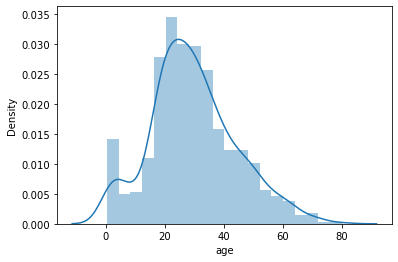

In [42]:
sns.distplot(df['age'])

In [43]:
df.describe()

,age,parch,fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.381594,32.204208
std,14.526497,0.806057,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,0.000000,31.000000
max,80.000000,6.000000,512.329200


In [44]:
df.describe(include=['object'])

,sex,class,embark_town,alive
count,891,891,889,891
unique,2,3,3,2
top,male,Third,Southampton,no
freq,577,491,644,549


In [45]:
df['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

C:\Users\dheof\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='alive', ylabel='count'>

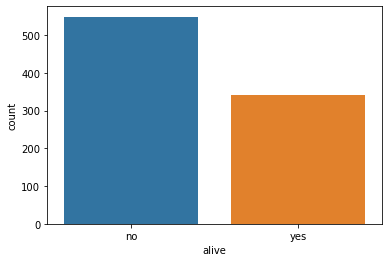

In [46]:
sns.countplot(df['alive'])

In [128]:
print('Tidak selamat', 549 / 891 * 100, '%')
print('Selamat', 342 / 891 * 100, '%')

Tidak selamat 61.61616161616161 %
Selamat 38.38383838383838 %


In [48]:
df.groupby(['alive','sex'])['alive'].count()

alive  sex   
no     female     81
       male      468
yes    female    233
       male      109
Name: alive, dtype: int64

## MISSING VALUES

In [70]:
df['alive'] = np.where(df['alive'] == 'yes', 1, 0)

In [49]:
simple_impute = SimpleImputer(strategy='median')
df[['age']] = simple_impute.fit_transform(df[['age']])

In [50]:
simple_impute = SimpleImputer(strategy='most_frequent')
df[['embark_town']] = simple_impute.fit_transform(df[['embark_town']])

In [51]:
df.isnull().sum()

sex            0
age            0
parch          0
fare           0
class          0
embark_town    0
alive          0
alone          0
dtype: int64

## DATA SPLITTING

In [71]:
x = df.drop(columns=['alive'])
y = df['alive']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 0
)

## PREP

In [73]:
ordinal_mapping = [
    {'col':'class',
    'mapping':{None:0,'First':1,'Second':2,'Third':3}}
]

ordinal_encoder = ce.OrdinalEncoder(cols = 'class',mapping = ordinal_mapping)
df_ordinal = ordinal_encoder.fit_transform(df['class'])

In [74]:
onehot = OneHotEncoder() 
binary_encoder = ce.BinaryEncoder()

transformer = ColumnTransformer(
    [
    ('one hot', onehot, ['sex', 'alone']),
    ('binary encoding', binary_encoder, ['embark_town']),
    ('ordinal', ordinal_encoder, ['class'])
    ],
remainder = 'passthrough')

In [75]:
x_train_prep = transformer.fit_transform(x_train)
x_test_prep = transformer.transform(x_test)

C:\Users\dheof\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\dheof\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Logreg

In [80]:
logreg = LogisticRegression()
logreg.fit(x_train_prep, y_train)

LogisticRegression()

In [81]:
# accuracy
logreg_cv = cross_val_score(logreg, x_train_prep, y_train, scoring = 'f1')
print(logreg_cv)
print(logreg_cv.mean())
print(logreg_cv.std())

[0.72222222 0.77777778 0.73786408 0.62745098 0.78632479]
0.7303279688773692
0.0567332332117278


In [85]:
# model perfomance in test set
y_pred = logreg.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       110
           1       0.75      0.65      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



## KNN

In [86]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_prep, y_train)

KNeighborsClassifier(n_neighbors=3)

In [87]:
knn_cv = cross_val_score(knn, x_train_prep, y_train, scoring = 'f1')
print(knn_cv)
print(knn_cv.mean())
print(knn_cv.std())

[0.6        0.61946903 0.56603774 0.55319149 0.63551402]
0.594842454090204
0.03115047085921908


In [88]:
y_pred = knn.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.78       110
           1       0.67      0.52      0.59        69

    accuracy                           0.72       179
   macro avg       0.70      0.68      0.68       179
weighted avg       0.71      0.72      0.71       179



## Tree

In [92]:
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(x_train_prep, y_train)

DecisionTreeClassifier(max_depth=3)

In [90]:
tree_cv = cross_val_score(tree, x_train_prep, y_train, scoring = 'f1')
print(tree_cv)
print(tree_cv.mean())
print(tree_cv.std())

[0.7184466  0.73684211 0.75728155 0.63636364 0.77777778]
0.7253423349488755
0.04871671990747608


In [93]:
y_pred = tree.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



## Random Forest

In [95]:
rf = RandomForestClassifier(n_estimators = 300, max_features = 5, max_depth = 3)
rf.fit(x_train_prep, y_train)

RandomForestClassifier(max_depth=3, max_features=5, n_estimators=300)

In [97]:
rf_cv = cross_val_score(rf, x_train_prep, y_train, scoring = 'f1')
print(rf_cv)
print(rf_cv.mean())
print(rf_cv.std())

[0.75       0.78       0.74       0.65957447 0.77669903]
0.7412546994422641
0.0436055353576772


In [99]:
y_pred = rf.predict(x_test_prep)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       110
           1       0.79      0.59      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.77       179



Logreg & RF

## Hyperparam Logreg

In [101]:
from sklearn.model_selection import StratifiedKFold

logreg = LogisticRegression()

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

hyperparam_space = {
    'model__C': [100,10,1,0.1,0.001,0.0001],
    'model__solver': ['liblinear', 'newton-cg']
}

skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring = 'f1', 
    n_jobs = -1
)

In [106]:
y_train

502    0
464    0
198    1
765    1
421    0
      ..
131    0
490    0
528    0
48     0
80     0
Name: alive, Length: 712, dtype: int32

In [108]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'alone']),
                                                                        ('binary '
                                                                         'encoding',
                                                                         BinaryEncoder(),
                                                                         ['embark_town']),
                  

In [109]:
grid_search.best_score_

0.7324952811507167

In [110]:
grid_search.best_score_
grid_search.best_params_

{'model__C': 100, 'model__solver': 'liblinear'}

## Hyperparam RF

In [122]:
rf = RandomForestClassifier()

estimator = Pipeline([
    ('transformer', transformer),
    ('model', rf)
])

hyperparam_space= {
    'model__min_samples_leaf':[1, 5, 10, 15, 20, 50],
    'model__max_depth':[2, 3, 4, 5, 6, 7], 
    'model__criterion':['gini', 'entropy'],
    'model__min_samples_split': [2,3,4,5,6],
    'model__bootstrap' : [False, True]
}

skfold = StratifiedKFold(n_splits=5)

grid_search = RandomizedSearchCV(
    estimator,
    param_distributions = hyperparam_space,
    cv = skfold,
    scoring = 'f1', 
    n_jobs = -1
)

In [123]:
grid_search.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(),
                                                                               ['sex',
                                                                                'alone']),
                                                                              ('binary '
                                                                               'encoding',
                                                                               BinaryEncoder(),
                                           

In [126]:
grid_search.best_score_

0.7472933191941991

In [127]:
grid_search.best_params_

{'model__min_samples_split': 3,
 'model__min_samples_leaf': 5,
 'model__max_depth': 7,
 'model__criterion': 'gini',
 'model__bootstrap': False}